In [1]:
import sys
import os

sys.path.append(os.getcwd())

import signal
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Sudoku import Sudoku
from AStarSolver import AStarSolver, Node
from CSPSolver import CSPSolver
from heuristics import h_domain_sum, h_zero

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
INSTANCES = [
    ("hardest", "benchmarks/hardest.txt"),
    ("easy", "benchmarks/easy.txt"),
    ("top95", "benchmarks/top95.txt"),
]

CONFIGURATIONS = [
    {
        "alg": "CSP",
        "h": "-",
        "strat": "-"
    },
    {
        "alg": "A*",
        "h": "DomainSum",
        "h_func": h_domain_sum,
        "strat": "MRV",
        "strat_enum": Sudoku.ActionsStrategy.MRV
    },
    {
        "alg": "A*",
        "h": "Zero",
        "h_func": h_zero,
        "strat": "MRV",
        "strat_enum": Sudoku.ActionsStrategy.MRV
    },
    {
        "alg": "A*",
        "h": "DomainSum",
        "h_func": h_domain_sum,
        "strat": "First",
        "strat_enum": Sudoku.ActionsStrategy.FIRST
    },
    {
        "alg": "A*",
        "h": "DomainSum",
        "h_func": h_domain_sum,
        "strat": "Random",
        "strat_enum": Sudoku.ActionsStrategy.RANDOM
    },
]

LIMIT = 10


In [3]:
def load_puzzles(filepath):
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    return lines[:LIMIT]

In [4]:
class TimeoutException(Exception):
    pass


def timeout_handler(signum, frame):
    raise TimeoutException("Timeout reached")


TIMEOUT = 5

In [5]:
def run_test(puzzle_str, config):
    """Esegue un singolo test"""
    puzzle = Sudoku.from_string(puzzle_str)

    # Timeout
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(TIMEOUT)

    start = time.perf_counter()
    nodes_exp = 0
    nodes_gen = 0
    max_frontier = 0
    max_explored = 0
    status = "FAIL"

    try:
        if config["alg"] == "A*":
            solver = AStarSolver(heuristic_func=config["h_func"],
                                 strategy=config["strat_enum"])
            sol = solver.solve(puzzle)
            nodes_exp = solver.nodes_expanded
            nodes_gen = solver.nodes_generated
            max_frontier = solver.max_frontier_size
            max_explored = solver.max_explored_size
        elif config["alg"] == "CSP":
            solver = CSPSolver()
            sol = solver.solve(puzzle)
            nodes_exp = 0
            nodes_gen = 0
            max_frontier = 0
            max_explored = 0

        elapsed = time.perf_counter() - start
        signal.alarm(0)
        status = "SOLVED" if sol else "UNSOLVED"

    except TimeoutException:
        signal.alarm(0)
        elapsed = TIMEOUT
        status = "TIMEOUT"
    except Exception as e:
        signal.alarm(0)
        elapsed = TIMEOUT
        status = "ERROR"
        print(f"Error: {e}")

    # Calculate metrics
    avg_bf = nodes_gen / nodes_exp if nodes_exp > 0 else 0
    max_memory = (max_frontier + max_explored)

    return {
        "Time": elapsed,
        "Nodes_Expanded": nodes_exp,
        "Nodes_Generated": nodes_gen,
        "Avg_BF": avg_bf,
        "Max_Frontier": max_frontier,
        "Max_Explored": max_explored,
        "Max_Memory": max_memory,
        "Status": status
    }

In [6]:
import pandas as pd

results = []

print("Inizio Benchmark...")

for dataset_name, filepath in INSTANCES:
    print(f"\nProcessing Dataset: {dataset_name}")
    puzzles = load_puzzles(filepath)

    for i, p_str in enumerate(puzzles):
        print(f"  Puzzle {i+1}/{len(puzzles)}")

        for config in CONFIGURATIONS:

            res = run_test(p_str, config)

            entry = {
                "Dataset": dataset_name,
                "ID": i,
                "Algorithm": config["alg"],
                "Heuristic": config["h"],
                "Strategy": config["strat"],
                "Config_Label":
                f"{config['alg']} ({config['h']}, {config['strat']})",
                "Time": res["Time"],
                "Nodes_Expanded": res["Nodes_Expanded"],
                "Nodes_Generated": res["Nodes_Generated"],
                "Avg_BF": res["Avg_BF"],
                "Max_Frontier": res["Max_Frontier"],
                "Max_Explored": res["Max_Explored"],
                "Max_Memory": res["Max_Memory"],
                "Status": res["Status"]
            }
            results.append(entry)

df = pd.DataFrame(results)
display(df.head())

Inizio Benchmark...

Processing Dataset: hardest
  Puzzle 1/10
  Puzzle 2/10
  Puzzle 2/10
  Puzzle 3/10
  Puzzle 3/10
  Puzzle 4/10
  Puzzle 4/10
  Puzzle 5/10
  Puzzle 5/10
  Puzzle 6/10
  Puzzle 6/10
  Puzzle 7/10
  Puzzle 7/10
  Puzzle 8/10
  Puzzle 8/10
  Puzzle 9/10
  Puzzle 9/10
  Puzzle 10/10
  Puzzle 10/10

Processing Dataset: easy
  Puzzle 1/10
  Puzzle 2/10

Processing Dataset: easy
  Puzzle 1/10
  Puzzle 2/10
  Puzzle 3/10
  Puzzle 3/10
  Puzzle 4/10
  Puzzle 4/10
  Puzzle 5/10
  Puzzle 6/10
  Puzzle 5/10
  Puzzle 6/10
  Puzzle 7/10
  Puzzle 7/10
  Puzzle 8/10
  Puzzle 9/10
  Puzzle 8/10
  Puzzle 9/10
  Puzzle 10/10
  Puzzle 10/10

Processing Dataset: top95
  Puzzle 1/10

Processing Dataset: top95
  Puzzle 1/10
  Puzzle 2/10
  Puzzle 2/10
  Puzzle 3/10
  Puzzle 3/10
  Puzzle 4/10
  Puzzle 4/10
  Puzzle 5/10
  Puzzle 5/10
  Puzzle 6/10
  Puzzle 6/10
  Puzzle 7/10
  Puzzle 7/10
  Puzzle 8/10
  Puzzle 8/10
  Puzzle 9/10
  Puzzle 9/10
  Puzzle 10/10
  Puzzle 10/10


,Dataset,ID,Algorithm,Heuristic,Strategy,Config_Label,Time,Nodes_Expanded,Nodes_Generated,Avg_BF,Max_Frontier,Max_Explored,Max_Memory,Status
0,hardest,0,CSP,-,-,"CSP (-, -)",0.035012,0,0,0.000000,0,0,0,SOLVED
1,hardest,0,A*,DomainSum,MRV,"A* (DomainSum, MRV)",0.669184,4322,4763,1.102036,441,4322,4763,SOLVED
2,hardest,0,A*,Zero,MRV,"A* (Zero, MRV)",0.271591,5878,5879,1.000170,257,5878,6135,SOLVED
3,hardest,0,A*,DomainSum,First,"A* (DomainSum, First)",5.000000,0,0,0.000000,0,0,0,TIMEOUT
4,hardest,0,A*,DomainSum,Random,"A* (DomainSum, Random)",5.000000,0,0,0.000000,0,0,0,TIMEOUT


In [7]:
df.to_csv("benchmark_results.csv", index=False)
display(df.head())

,Dataset,ID,Algorithm,Heuristic,Strategy,Config_Label,Time,Nodes_Expanded,Nodes_Generated,Avg_BF,Max_Frontier,Max_Explored,Max_Memory,Status
0,hardest,0,CSP,-,-,"CSP (-, -)",0.035012,0,0,0.000000,0,0,0,SOLVED
1,hardest,0,A*,DomainSum,MRV,"A* (DomainSum, MRV)",0.669184,4322,4763,1.102036,441,4322,4763,SOLVED
2,hardest,0,A*,Zero,MRV,"A* (Zero, MRV)",0.271591,5878,5879,1.000170,257,5878,6135,SOLVED
3,hardest,0,A*,DomainSum,First,"A* (DomainSum, First)",5.000000,0,0,0.000000,0,0,0,TIMEOUT
4,hardest,0,A*,DomainSum,Random,"A* (DomainSum, Random)",5.000000,0,0,0.000000,0,0,0,TIMEOUT


In [7]:
import pandas as pd

df = pd.read_csv("benchmark_results.csv")

df.head()

,Dataset,ID,Algorithm,Heuristic,Strategy,Config_Label,Time,Nodes_Expanded,Nodes_Generated,Avg_BF,Max_Frontier,Max_Explored,Max_Memory,Status
0,hardest,0,CSP,-,-,"CSP (-, -)",0.035012,0,0,0.000000,0,0,0,SOLVED
1,hardest,0,A*,DomainSum,MRV,"A* (DomainSum, MRV)",0.669184,4322,4763,1.102036,441,4322,4763,SOLVED
2,hardest,0,A*,Zero,MRV,"A* (Zero, MRV)",0.271591,5878,5879,1.000170,257,5878,6135,SOLVED
3,hardest,0,A*,DomainSum,First,"A* (DomainSum, First)",5.000000,0,0,0.000000,0,0,0,TIMEOUT
4,hardest,0,A*,DomainSum,Random,"A* (DomainSum, Random)",5.000000,0,0,0.000000,0,0,0,TIMEOUT


In [8]:
time_table = df.groupby(["Dataset", "Config_Label"])["Time"].mean().unstack()
time_table


Config_Label,"A* (DomainSum, First)","A* (DomainSum, MRV)","A* (DomainSum, Random)","A* (Zero, MRV)","CSP (-, -)"
Dataset,,,,,
easy,0.722827,0.011822,3.502986,0.006625,0.004128
hardest,2.582568,0.108284,5.000000,0.053272,0.017388
top95,5.000000,3.405364,5.000000,3.535651,1.408823


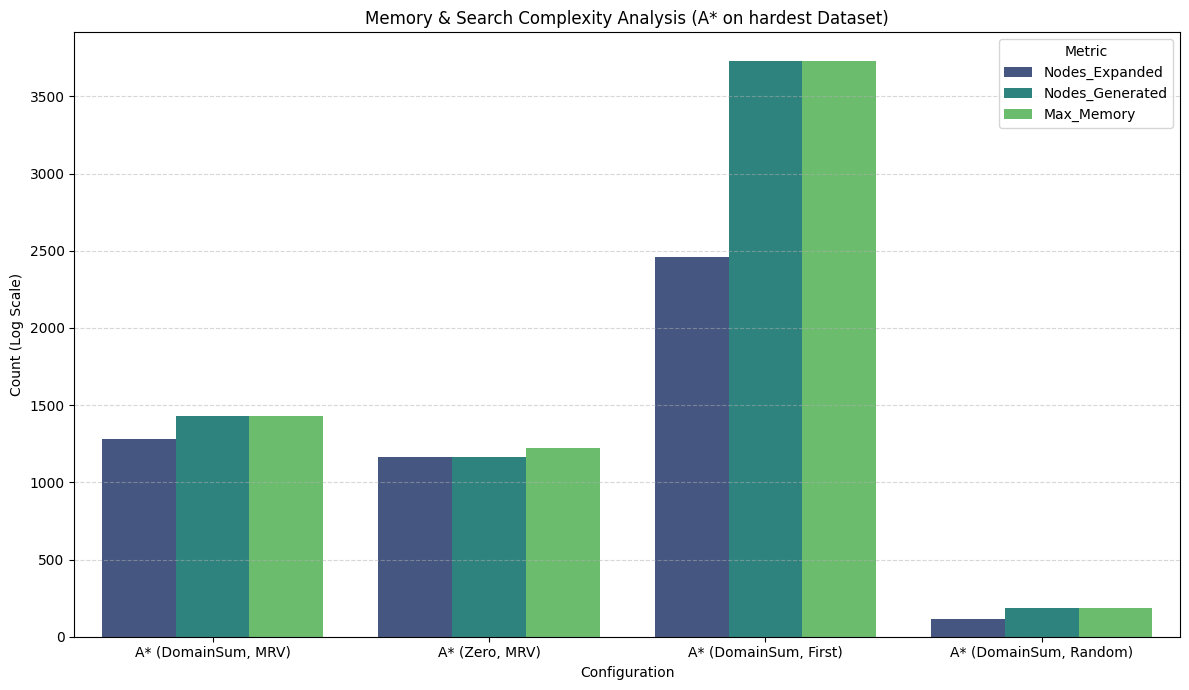

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_astar = df[(df["Algorithm"] == "A*") & (df["Dataset"] == "hardest") &
              (df["Status"] == "SOLVED")].copy()

df_melted = df_astar.melt(
    id_vars=["Config_Label"],
    value_vars=["Nodes_Expanded", "Nodes_Generated", "Max_Memory"],
    var_name="Metric",
    value_name="Count")

plt.figure(figsize=(12, 7))

chart = sns.barplot(data=df_melted,
                    x="Config_Label",
                    y="Count",
                    hue="Metric",
                    palette="viridis",
                    errorbar=None)

plt.title("Memory & Search Complexity Analysis (A* on hardest Dataset)")
plt.ylabel("Count (Log Scale)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

/var/folders/56/pyblk81s35q_t23my1ytkwf40000gn/T/ipykernel_1403/1956448645.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_astar, x="Config_Label", y="Avg_BF", palette="viridis")
/var/folders/56/pyblk81s35q_t23my1ytkwf40000gn/T/ipykernel_1403/1956448645.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


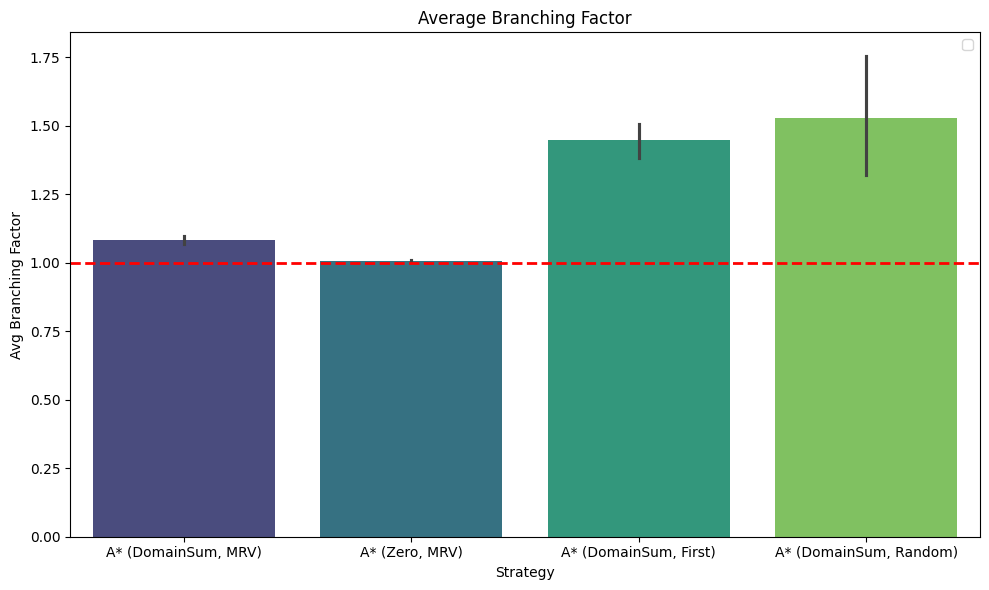

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df_astar = df[(df["Algorithm"] == "A*") & (df["Avg_BF"] > 0)]

plt.figure(figsize=(10, 6))

sns.barplot(data=df_astar, x="Config_Label", y="Avg_BF", palette="viridis")

plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2)

plt.title("Average Branching Factor")
plt.ylabel("Avg Branching Factor")
plt.xlabel("Strategy")
plt.legend()
plt.tight_layout()

plt.show()

In [8]:
solved_df = df[df["Status"] == "SOLVED"]

summary = solved_df.groupby(["Dataset",
                             "Config_Label"])["Time"].mean().unstack()
display(summary)

Config_Label,"A* (DomainSum, First)","A* (DomainSum, MRV)","A* (DomainSum, Random)","A* (Zero, MRV)","CSP (-, -)"
Dataset,,,,,
easy,0.247585,0.011822,0.009954,0.006625,0.004128
hardest,1.546526,0.108284,NaN,0.053272,0.017388
top95,NaN,1.013411,NaN,0.118835,1.408823


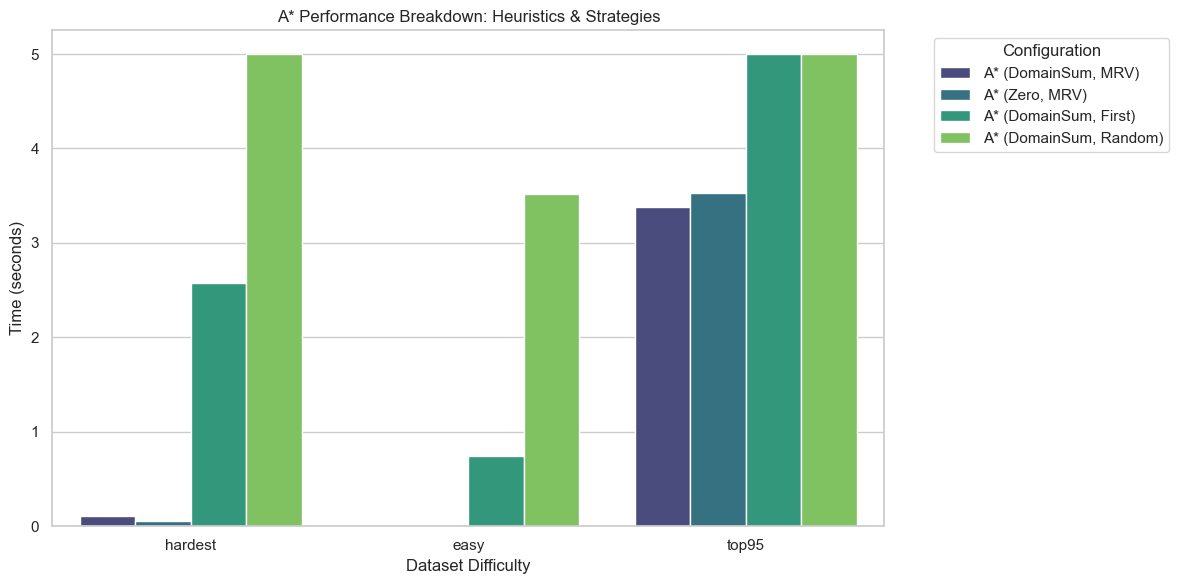

In [ ]:
df_astar_only = df[df["Algorithm"] == "A*"]

if not df_astar_only.empty:
    plt.figure(figsize=(12, 6))

    chart_astar = sns.barplot(data=df_astar_only,
                              x="Dataset",
                              y="Time",
                              hue="Config_Label",
                              errorbar=None,
                              palette="viridis")

    plt.title("A* Performance Breakdown: Heuristics & Strategies")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Dataset Difficulty")
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc='upper left',
               title="Configuration")
    plt.tight_layout()
    plt.show()
else:
    print("Nessun dato A* trovato nei puzzle risolti.")

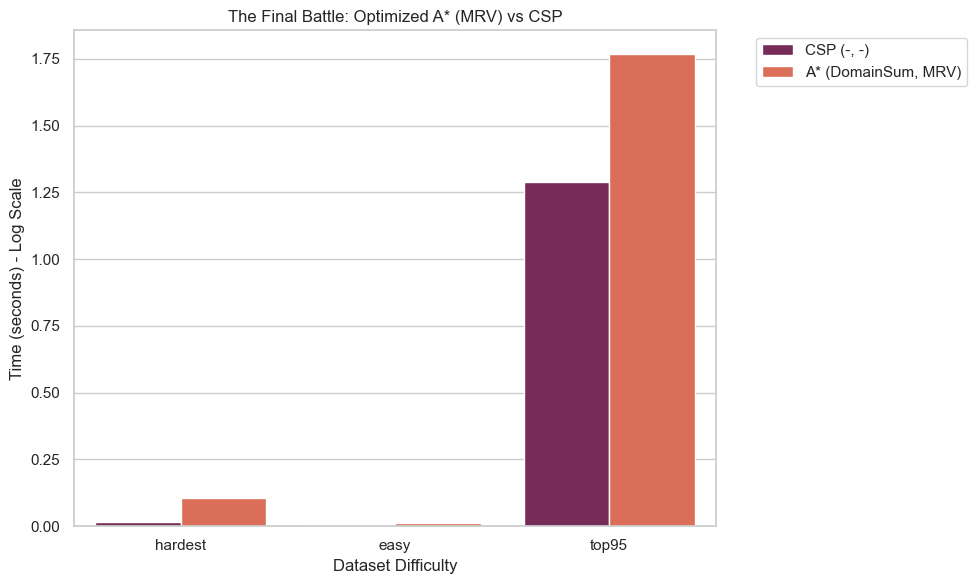

In [ ]:
is_csp = solved_df["Algorithm"] == "CSP"

is_best_astar = (solved_df["Heuristic"]
                 == "DomainSum") & (solved_df["Strategy"] == "MRV")
df_best_vs_best = solved_df[is_csp | is_best_astar]

if not df_best_vs_best.empty:
    plt.figure(figsize=(10, 6))

    chart_comparison = sns.barplot(data=df_best_vs_best,
                                   x="Dataset",
                                   y="Time",
                                   hue="Config_Label",
                                   errorbar=None,
                                   palette="rocket")

    plt.title("The Final Battle: Optimized A* (MRV) vs CSP")
    plt.ylabel("Time (seconds) - Log Scale")
    plt.xlabel("Dataset Difficulty")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [33]:
plt.figure(figsize=(12, 6))

sns.countplot(data=df[df["Status"] == "SOLVED"],
              x="Dataset",
              hue="Config_Label")

plt.title("Solved Puzzles")
plt.ylabel("Number of Solved Puzzles")
plt.xlabel("Dataset")

plt.axhline(y=LIMIT, color='r', linestyle='--', alpha=0.5, label="Max Puzzles")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
LIMIT = 95

configs = [
    {
        "label": "A* (DomainSum + MRV)",
        "alg": "A*",
        "h_func": h_domain_sum,
        "strat_enum": Sudoku.ActionsStrategy.MRV
    },
    {
        "label": "CSP",
        "alg": "A*",
        "h_func": None,
        "strat_enum": Sudoku.ActionsStrategy.MRV
    },
]

In [19]:
df_95 = pd.DataFrame(results)

In [27]:
df_95.head()

,Puzzle_ID,Algorithm,Time,Expanded,Generated,Avg_BF,Max_Memory,Status
0,0,A* (DomainSum + MRV),0.447223,2265,2593,1.144812,4418472,SOLVED
1,0,A* (RANDOM + MRV),5.000000,0,0,0.000000,0,TIMEOUT
2,0,A* (RANDOM + MRV),5.000000,0,0,0.000000,0,TIMEOUT
3,0,A* (DomainSum + ZERO),0.157275,3722,3723,1.000269,6343992,SOLVED
4,1,A* (DomainSum + MRV),0.047056,425,488,1.148235,831552,SOLVED


In [26]:
summary = df_95.groupby("Algorithm")[[
    "Time", "Expanded", "Avg_BF", "Max_Memory"
]].mean()
display(summary)

,Time,Expanded,Avg_BF,Max_Memory
Algorithm,,,,
A* (DomainSum + MRV),1.514366,2688.894737,0.865846,5.107121e+06
A* (DomainSum + ZERO),1.748266,5310.863158,0.737043,9.050966e+06
A* (RANDOM + MRV),4.747050,252.900000,0.100604,6.338073e+05
